In [107]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [109]:
!cp /content/drive/MyDrive/Kaggle_credentials/kaggle.json ~/.kaggle/kaggle.json

In [110]:
! chmod 600 ~/.kaggle/kaggle.json

In [111]:
# ! kaggle competitions download -c walmart-recruiting-store-sales-forecasting

In [112]:
# ! unzip /content/walmart-recruiting-store-sales-forecasting.zip
# ! unzip /content/train.csv.zip
# ! unzip /content/test.csv.zip
# ! unzip /content/features.csv.zip
# ! unzip /content/sampleSubmission.csv.zip

In [113]:
# !pip install wandb -qU

# # Clean up all related packages
# !pip uninstall -y pmdarima numpy scipy statsmodels

# # Reinstall pinned, compatible versions
# !pip install numpy==1.24.4 scipy==1.10.1 statsmodels==0.13.5 pmdarima==2.0.3

In [114]:
import wandb
import random
import math

In [115]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

m,▁
max_d,▁
max_p,▁
max_q,▁
m,52
max_d,1
max_p,3
max_q,3
seasonal,True


=== BLOCK 1: DATA LOADING & EXPLORATION ===
Loading datasets...
Dataset Info:
  train_shape: (421570, 5)
  features_shape: (8190, 12)
  stores_shape: (45, 3)
  test_shape: (115064, 4)
  unique_stores: 45
  unique_departments: 81
  date_range_train: 2010-02-05 to 2012-10-26
  total_sales: 6737218987.11


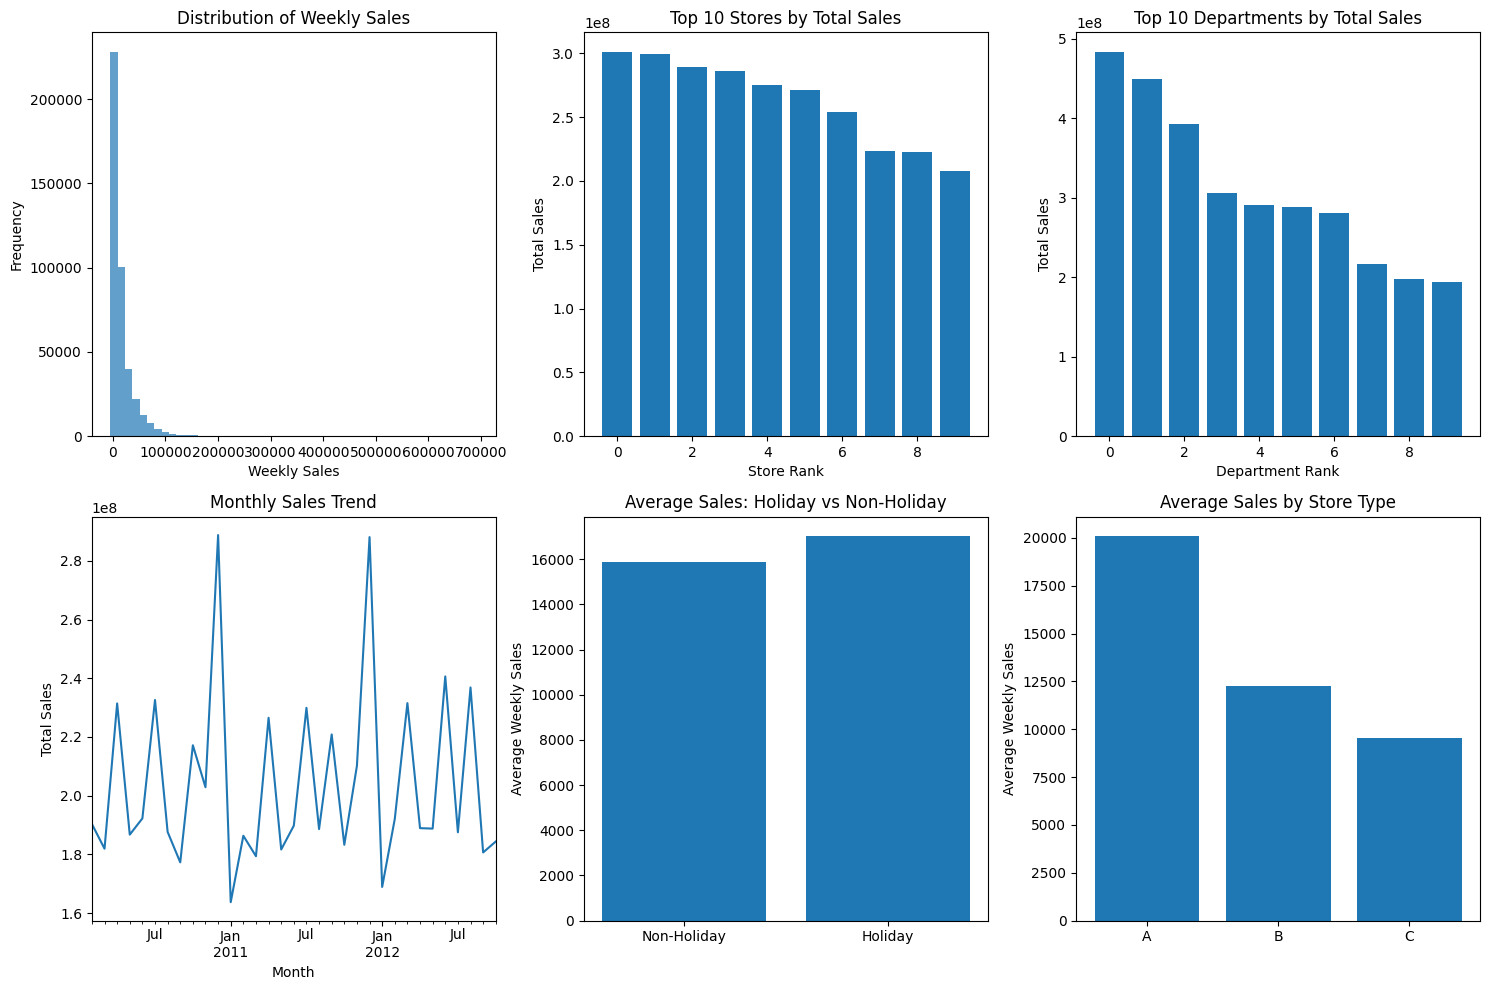

Key Insights: {'top_performing_store': 20, 'top_performing_department': 92, 'holiday_sales_boost': 7.133805219708678, 'sales_std_dev': 22711.18351916313, 'negative_sales_count': 1285}


holiday_sales_boost,▁
negative_sales_count,▁
sales_std_dev,▁
top_performing_department,▁
top_performing_store,▁
total_sales,▁
unique_departments,▁
unique_stores,▁
date_range_train,2010-02-05 to 2012-1...
holiday_sales_boost,7.13381
negative_sales_count,1285


In [116]:
# Block 1: Data Loading & Exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import wandb

# Initialize wandb for data exploration
wandb.init(
    project="walmart-sales-forecasting",
    name="ARIMA_Data_Exploration",
    tags=["ARIMA", "data-exploration"]
)

print("=== BLOCK 1: DATA LOADING & EXPLORATION ===")

# Load all datasets
print("Loading datasets...")
train_df = pd.read_csv("/content/train.csv")
features_df = pd.read_csv("/content/features.csv")
stores_df = pd.read_csv("/content/stores.csv")
test_df = pd.read_csv("/content/test.csv")
sample_submission = pd.read_csv("/content/sampleSubmission.csv")

# Basic info
datasets_info = {
    "train_shape": train_df.shape,
    "features_shape": features_df.shape,
    "stores_shape": stores_df.shape,
    "test_shape": test_df.shape,
    "unique_stores": train_df['Store'].nunique(),
    "unique_departments": train_df['Dept'].nunique(),
    "date_range_train": f"{train_df['Date'].min()} to {train_df['Date'].max()}",
    "total_sales": train_df['Weekly_Sales'].sum()
}

print("Dataset Info:")
for key, value in datasets_info.items():
    print(f"  {key}: {value}")

# Log basic statistics
wandb.log(datasets_info)

# Analyze sales distribution
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(train_df['Weekly_Sales'], bins=50, alpha=0.7)
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')

plt.subplot(2, 3, 2)
store_sales = train_df.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False)
plt.bar(range(len(store_sales.head(10))), store_sales.head(10).values)
plt.title('Top 10 Stores by Total Sales')
plt.xlabel('Store Rank')
plt.ylabel('Total Sales')

plt.subplot(2, 3, 3)
dept_sales = train_df.groupby('Dept')['Weekly_Sales'].sum().sort_values(ascending=False)
plt.bar(range(len(dept_sales.head(10))), dept_sales.head(10).values)
plt.title('Top 10 Departments by Total Sales')
plt.xlabel('Department Rank')
plt.ylabel('Total Sales')

plt.subplot(2, 3, 4)
train_df['Date'] = pd.to_datetime(train_df['Date'])
monthly_sales = train_df.groupby(train_df['Date'].dt.to_period('M'))['Weekly_Sales'].sum()
monthly_sales.plot()
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')

plt.subplot(2, 3, 5)
holiday_sales = train_df.groupby('IsHoliday')['Weekly_Sales'].mean()
plt.bar(['Non-Holiday', 'Holiday'], holiday_sales.values)
plt.title('Average Sales: Holiday vs Non-Holiday')
plt.ylabel('Average Weekly Sales')

plt.subplot(2, 3, 6)
store_type_sales = train_df.merge(stores_df, on='Store').groupby('Type')['Weekly_Sales'].mean()
plt.bar(store_type_sales.index, store_type_sales.values)
plt.title('Average Sales by Store Type')
plt.ylabel('Average Weekly Sales')

plt.tight_layout()
plt.savefig('data_exploration.png', dpi=300, bbox_inches='tight')
wandb.log({"data_exploration": wandb.Image('data_exploration.png')})
plt.show()

# Log key insights
insights = {
    "top_performing_store": int(store_sales.index[0]),
    "top_performing_department": int(dept_sales.index[0]),
    "holiday_sales_boost": float(holiday_sales[True] / holiday_sales[False] - 1) * 100,
    "sales_std_dev": float(train_df['Weekly_Sales'].std()),
    "negative_sales_count": int((train_df['Weekly_Sales'] < 0).sum())
}

wandb.log(insights)
print(f"Key Insights: {insights}")

wandb.finish()

In [117]:
# Block 2: Data Preprocessing
import pandas as pd
import numpy as np
import wandb

wandb.init(
    project="walmart-sales-forecasting",
    name="ARIMA_Data_Preprocessing",
    tags=["ARIMA", "preprocessing"]
)

print("=== BLOCK 2: DATA PREPROCESSING ===")

# Load data (assuming from previous block or reload)
train_df = pd.read_csv("/content/train.csv")
features_df = pd.read_csv("/content/features.csv")
stores_df = pd.read_csv("/content/stores.csv")

def preprocess_walmart_data(train_df, features_df, stores_df):
    """Comprehensive preprocessing for Walmart data"""

    preprocessing_log = {}

    # Convert dates
    train_df['Date'] = pd.to_datetime(train_df['Date'])
    features_df['Date'] = pd.to_datetime(features_df['Date'])

    # Log date info
    preprocessing_log['date_range'] = {
        'start': str(train_df['Date'].min()),
        'end': str(train_df['Date'].max()),
        'total_weeks': len(train_df['Date'].unique())
    }

    # Merge datasets
    print("Merging datasets...")
    merged_df = train_df.merge(features_df, on=['Store', 'Date'], how='left', suffixes=('', '_feat'))
    merged_df = merged_df.merge(stores_df, on='Store', how='left')

    # Handle duplicate IsHoliday columns
    if 'IsHoliday_feat' in merged_df.columns:
        merged_df = merged_df.drop('IsHoliday_feat', axis=1)

    # Handle missing values
    missing_before = merged_df.isnull().sum().sum()

    # Fill missing values strategically
    numeric_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
                   'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

    for col in numeric_cols:
        if col in merged_df.columns:
            # Forward fill then backward fill
            merged_df[col] = merged_df.groupby('Store')[col].fillna(method='ffill').fillna(method='bfill')
            # If still missing, fill with median
            merged_df[col] = merged_df[col].fillna(merged_df[col].median())

    missing_after = merged_df.isnull().sum().sum()

    preprocessing_log['missing_values'] = {
        'before': int(missing_before),
        'after': int(missing_after),
        'reduction': int(missing_before - missing_after)
    }

    # Handle negative sales (mark as outliers but keep for now)
    negative_sales = (merged_df['Weekly_Sales'] < 0).sum()
    preprocessing_log['negative_sales_count'] = int(negative_sales)

    # Create additional time features
    merged_df['Year'] = merged_df['Date'].dt.year
    merged_df['Month'] = merged_df['Date'].dt.month
    merged_df['Week'] = merged_df['Date'].dt.isocalendar().week
    merged_df['DayOfYear'] = merged_df['Date'].dt.dayofyear

    # Sort data
    merged_df = merged_df.sort_values(['Store', 'Dept', 'Date'])

    preprocessing_log['final_shape'] = merged_df.shape
    preprocessing_log['stores_count'] = merged_df['Store'].nunique()
    preprocessing_log['departments_count'] = merged_df['Dept'].nunique()

    return merged_df, preprocessing_log

# Perform preprocessing
merged_data, prep_log = preprocess_walmart_data(train_df, features_df, stores_df)

print("Preprocessing completed:")
print(f"  Final shape: {prep_log['final_shape']}")
print(f"  Missing values reduced from {prep_log['missing_values']['before']} to {prep_log['missing_values']['after']}")
print(f"  Negative sales: {prep_log['negative_sales_count']}")

# Log preprocessing results
wandb.log(prep_log)

# Save preprocessed data
merged_data.to_pickle('preprocessed_data.pkl')
print("Preprocessed data saved as 'preprocessed_data.pkl'")

# Log as artifact
artifact = wandb.Artifact('preprocessed_data', type='dataset')
artifact.add_file('preprocessed_data.pkl')
wandb.log_artifact(artifact)

wandb.finish()

=== BLOCK 2: DATA PREPROCESSING ===
Merging datasets...
Preprocessing completed:
  Final shape: (421570, 20)
  Missing values reduced from 1422431 to 0
  Negative sales: 1285
Preprocessed data saved as 'preprocessed_data.pkl'


departments_count,▁
negative_sales_count,▁
stores_count,▁
departments_count,81
negative_sales_count,1285
stores_count,45


In [118]:
# Block 3: Time Series Preparation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import wandb

wandb.init(
    project="walmart-sales-forecasting",
    name="ARIMA_TimeSeries_Preparation",
    tags=["ARIMA", "time-series", "preparation"]
)

print("=== BLOCK 3: TIME SERIES PREPARATION ===")

# Load preprocessed data
try:
    merged_data = pd.read_pickle('preprocessed_data.pkl')
    print("Loaded preprocessed data from pickle")
except:
    # Fallback: reload and preprocess
    print("Reloading and preprocessing data...")
    # ... (preprocessing code from Block 2)

def create_store_aggregated_data(data):
    """Create store-level aggregated time series"""

    # Aggregate by Store and Date
    store_ts = data.groupby(['Store', 'Date']).agg({
        'Weekly_Sales': 'sum',
        'Temperature': 'mean',
        'Fuel_Price': 'mean',
        'CPI': 'mean',
        'Unemployment': 'mean',
        'IsHoliday': 'max',
        'Size': 'first',
        'Type': 'first'
    }).reset_index()

    return store_ts

def analyze_time_series_properties(ts_data, store_id):
    """Analyze time series properties for stationarity and seasonality"""

    ts = ts_data.set_index('Date')['Weekly_Sales']

    # Stationarity test
    adf_result = adfuller(ts.dropna())
    stationarity = {
        'adf_statistic': adf_result[0],
        'p_value': adf_result[1],
        'is_stationary': adf_result[1] < 0.05,
        'critical_values': adf_result[4]
    }

    # Basic statistics
    stats = {
        'mean': ts.mean(),
        'std': ts.std(),
        'min': ts.min(),
        'max': ts.max(),
        'trend': 'increasing' if ts.iloc[-12:].mean() > ts.iloc[:12].mean() else 'decreasing'
    }

    return stationarity, stats

def plot_time_series_analysis(ts_data, store_id):
    """Create comprehensive time series analysis plots"""

    ts = ts_data.set_index('Date')['Weekly_Sales']

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Original time series
    axes[0, 0].plot(ts.index, ts.values)
    axes[0, 0].set_title(f'Store {store_id} - Weekly Sales Time Series')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Weekly Sales')

    # Seasonal decomposition
    if len(ts) >= 24:  # Need at least 2 cycles for decomposition
        decomposition = seasonal_decompose(ts, model='additive', period=52)  # Yearly seasonality

        axes[0, 1].plot(decomposition.trend.dropna())
        axes[0, 1].set_title('Trend Component')

        axes[1, 0].plot(decomposition.seasonal.dropna())
        axes[1, 0].set_title('Seasonal Component')

        axes[1, 1].plot(decomposition.resid.dropna())
        axes[1, 1].set_title('Residual Component')

    plt.tight_layout()
    filename = f'ts_analysis_store_{store_id}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

    return filename

# Create aggregated time series data
print("Creating store-level aggregated time series...")
store_aggregated = create_store_aggregated_data(merged_data)

# Select stores for analysis
store_sales_total = store_aggregated.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False)
selected_stores = store_sales_total.head(10).index.tolist()

print(f"Selected top 10 stores for time series analysis: {selected_stores}")
wandb.log({"selected_stores_count": len(selected_stores), "selected_stores": selected_stores})

# Analyze each store's time series
store_analysis = {}

for store_id in selected_stores:
    print(f"\nAnalyzing Store {store_id}...")

    store_data = store_aggregated[store_aggregated['Store'] == store_id].copy()
    store_data = store_data.sort_values('Date')

    if len(store_data) < 10:  # Skip stores with insufficient data
        print(f"Skipping store {store_id} - insufficient data")
        continue

    # Analyze time series properties
    stationarity, stats = analyze_time_series_properties(store_data, store_id)

    # Create analysis plots
    plot_filename = plot_time_series_analysis(store_data, store_id)

    # Store results
    store_analysis[store_id] = {
        'data_points': len(store_data),
        'stationarity': stationarity,
        'statistics': stats,
        'plot_file': plot_filename
    }

    # Log individual store metrics
    wandb.log({
        f'store_{store_id}_data_points': len(store_data),
        f'store_{store_id}_is_stationary': stationarity['is_stationary'],
        f'store_{store_id}_adf_pvalue': stationarity['p_value'],
        f'store_{store_id}_mean_sales': stats['mean'],
        f'store_{store_id}_sales_std': stats['std'],
        f'store_{store_id}_trend': stats['trend'],
        f'store_{store_id}_analysis': wandb.Image(plot_filename)
    })

    print(f"  Data points: {len(store_data)}")
    print(f"  Stationary: {stationarity['is_stationary']} (p-value: {stationarity['p_value']:.4f})")
    print(f"  Mean sales: {stats['mean']:.2f}")
    print(f"  Trend: {stats['trend']}")

# Overall analysis summary
stationary_stores = sum(1 for analysis in store_analysis.values() if analysis['stationarity']['is_stationary'])
total_stores_analyzed = len(store_analysis)

summary_stats = {
    'total_stores_analyzed': total_stores_analyzed,
    'stationary_stores': stationary_stores,
    'non_stationary_stores': total_stores_analyzed - stationary_stores,
    'avg_data_points': np.mean([analysis['data_points'] for analysis in store_analysis.values()]),
    'avg_sales': np.mean([analysis['statistics']['mean'] for analysis in store_analysis.values()]),
    'stores_need_differencing': total_stores_analyzed - stationary_stores
}

wandb.log(summary_stats)

print(f"\n=== TIME SERIES ANALYSIS SUMMARY ===")
print(f"Stores analyzed: {total_stores_analyzed}")
print(f"Stationary stores: {stationary_stores}")
print(f"Non-stationary stores: {total_stores_analyzed - stationary_stores}")
print(f"Average data points per store: {summary_stats['avg_data_points']:.1f}")

# Save time series data and analysis
store_aggregated.to_pickle('store_timeseries_data.pkl')
np.save('store_analysis.npy', store_analysis)

# Log as artifacts
ts_artifact = wandb.Artifact('timeseries_data', type='dataset')
ts_artifact.add_file('store_timeseries_data.pkl')
wandb.log_artifact(ts_artifact)

analysis_artifact = wandb.Artifact('timeseries_analysis', type='analysis')
analysis_artifact.add_file('store_analysis.npy')
wandb.log_artifact(analysis_artifact)

wandb.finish()

=== BLOCK 3: TIME SERIES PREPARATION ===
Loaded preprocessed data from pickle
Creating store-level aggregated time series...
Selected top 10 stores for time series analysis: [20, 4, 14, 13, 2, 10, 27, 6, 1, 39]

Analyzing Store 20...
  Data points: 143
  Stationary: True (p-value: 0.0000)
  Mean sales: 2107676.87
  Trend: increasing

Analyzing Store 4...
  Data points: 143
  Stationary: True (p-value: 0.0478)
  Mean sales: 2094712.96
  Trend: increasing

Analyzing Store 14...
  Data points: 143
  Stationary: False (p-value: 0.0679)
  Mean sales: 2020978.40
  Trend: decreasing

Analyzing Store 13...
  Data points: 143
  Stationary: True (p-value: 0.0000)
  Mean sales: 2003620.31
  Trend: increasing

Analyzing Store 2...
  Data points: 143
  Stationary: True (p-value: 0.0040)
  Mean sales: 1925751.34
  Trend: decreasing

Analyzing Store 10...
  Data points: 143
  Stationary: True (p-value: 0.0000)
  Mean sales: 1899424.57
  Trend: decreasing

Analyzing Store 27...
  Data points: 143
  St

avg_data_points,▁
avg_sales,▁
non_stationary_stores,▁
selected_stores_count,▁
stationary_stores,▁
store_10_adf_pvalue,▁
store_10_data_points,▁
store_10_mean_sales,▁
store_10_sales_std,▁
store_13_adf_pvalue,▁
store_13_data_points,▁


In [119]:
# Block 4: ARIMA Model Training & Hyperparameter Tuning
import pandas as pd
import numpy as np
import itertools
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import wandb

wandb.init(
    project="walmart-sales-forecasting",
    name="ARIMA_Hyperparameter_Tuning",
    tags=["ARIMA", "hyperparameter-tuning", "training"]
)

print("=== BLOCK 4: ARIMA MODEL TRAINING & HYPERPARAMETER TUNING ===")

# Load time series data
try:
    store_ts_data = pd.read_pickle('store_timeseries_data.pkl')
    store_analysis = np.load('store_analysis.npy', allow_pickle=True).item()
    print("Loaded time series data and analysis")
except:
    print("Could not load time series data. Please run Block 3 first.")
    wandb.finish()
    exit()

class ARIMAHyperparameterTuner:
    def __init__(self, max_p=3, max_d=2, max_q=3):
        self.max_p = max_p
        self.max_d = max_d
        self.max_q = max_q
        self.results = {}

    def grid_search(self, timeseries, store_id):
        """Perform grid search for best ARIMA parameters"""

        print(f"Grid searching ARIMA parameters for Store {store_id}...")

        best_aic = float('inf')
        best_params = None
        best_model = None
        all_results = []

        p_range = range(0, self.max_p + 1)
        d_range = range(0, self.max_d + 1)
        q_range = range(0, self.max_q + 1)

        total_combinations = (self.max_p + 1) * (self.max_d + 1) * (self.max_q + 1)
        print(f"Testing {total_combinations} parameter combinations...")

        for i, (p, d, q) in enumerate(itertools.product(p_range, d_range, q_range)):
            try:
                # Fit ARIMA model
                model = ARIMA(timeseries, order=(p, d, q))
                fitted_model = model.fit()

                aic = fitted_model.aic
                bic = fitted_model.bic
                hqic = fitted_model.hqic

                result = {
                    'store_id': store_id,
                    'p': p, 'd': d, 'q': q,
                    'aic': aic, 'bic': bic, 'hqic': hqic,
                    'converged': fitted_model.mle_retvals['converged'] if hasattr(fitted_model, 'mle_retvals') else True
                }

                all_results.append(result)

                # Track best model by AIC
                if aic < best_aic:
                    best_aic = aic
                    best_params = (p, d, q)
                    best_model = fitted_model

                # Log progress
                if (i + 1) % 10 == 0:
                    print(f"  Completed {i + 1}/{total_combinations} combinations")

            except Exception as e:
                # Log failed combinations
                all_results.append({
                    'store_id': store_id,
                    'p': p, 'd': d, 'q': q,
                    'aic': np.inf, 'bic': np.inf, 'hqic': np.inf,
                    'converged': False,
                    'error': str(e)
                })
                continue

        return best_params, best_aic, best_model, all_results

def evaluate_arima_model(fitted_model, train_data, test_data):
    """Evaluate ARIMA model performance"""

    try:
        # Make predictions
        forecast = fitted_model.forecast(steps=len(test_data))

        # Calculate metrics
        mae = mean_absolute_error(test_data, forecast)
        rmse = np.sqrt(mean_squared_error(test_data, forecast))
        mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100

        return {
            'mae': mae,
            'rmse': rmse,
            'mape': mape,
            'forecast': forecast
        }
    except Exception as e:
        return {
            'mae': np.inf,
            'rmse': np.inf,
            'mape': np.inf,
            'error': str(e)
        }

# Select stores for modeling (top performers with sufficient data)
store_sales = store_ts_data.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False)
modeling_stores = []

for store_id in store_sales.index:
    store_data = store_ts_data[store_ts_data['Store'] == store_id]
    if len(store_data) >= 40:  # Need sufficient data for train/test split
        modeling_stores.append(store_id)
    if len(modeling_stores) >= 5:  # Limit to top 5 stores for computational efficiency
        break

print(f"Selected {len(modeling_stores)} stores for ARIMA modeling: {modeling_stores}")
wandb.log({"modeling_stores": modeling_stores, "modeling_stores_count": len(modeling_stores)})

# Initialize hyperparameter tuner
tuner = ARIMAHyperparameterTuner(max_p=3, max_d=2, max_q=3)

# Train and tune ARIMA models for each store
trained_models = {}
all_tuning_results = []

for store_id in modeling_stores:
    print(f"\n{'='*50}")
    print(f"TRAINING ARIMA MODEL FOR STORE {store_id}")
    print(f"{'='*50}")

    # Get store data
    store_data = store_ts_data[store_ts_data['Store'] == store_id].copy()
    store_data = store_data.sort_values('Date')
    store_ts = store_data.set_index('Date')['Weekly_Sales']

    # Train/test split (80/20)
    split_idx = int(len(store_ts) * 0.8)
    train_ts = store_ts.iloc[:split_idx]
    test_ts = store_ts.iloc[split_idx:]

    print(f"Train size: {len(train_ts)}, Test size: {len(test_ts)}")

    # Hyperparameter tuning
    best_params, best_aic, best_model, tuning_results = tuner.grid_search(train_ts, store_id)

    if best_model is not None:
        # Evaluate best model
        evaluation = evaluate_arima_model(best_model, train_ts, test_ts)

        # Store results
        trained_models[store_id] = {
            'best_params': best_params,
            'best_aic': best_aic,
            'model': best_model,
            'evaluation': evaluation,
            'train_size': len(train_ts),
            'test_size': len(test_ts)
        }

        print(f"Best parameters: ARIMA{best_params}")
        print(f"Best AIC: {best_aic:.2f}")
        print(f"Test MAE: {evaluation['mae']:.2f}")
        print(f"Test RMSE: {evaluation['rmse']:.2f}")
        print(f"Test MAPE: {evaluation['mape']:.2f}%")

        # Log to wandb
        wandb.log({
            f'store_{store_id}_best_p': best_params[0],
            f'store_{store_id}_best_d': best_params[1],
            f'store_{store_id}_best_q': best_params[2],
            f'store_{store_id}_best_aic': best_aic,
            f'store_{store_id}_test_mae': evaluation['mae'],
            f'store_{store_id}_test_rmse': evaluation['rmse'],
            f'store_{store_id}_test_mape': evaluation['mape'],
            f'store_{store_id}_train_size': len(train_ts),
            f'store_{store_id}_test_size': len(test_ts)
        })

    else:
        print(f"Failed to train ARIMA model for Store {store_id}")

    # Store all tuning results
    all_tuning_results.extend(tuning_results)

# Create summary of hyperparameter tuning results
tuning_df = pd.DataFrame(all_tuning_results)
successful_runs = tuning_df[tuning_df['aic'] != np.inf]

if len(successful_runs) > 0:
    # Analyze parameter frequency
    param_analysis = {
        'most_common_p': int(successful_runs['p'].mode().iloc[0]),
        'most_common_d': int(successful_runs['d'].mode().iloc[0]),
        'most_common_q': int(successful_runs['q'].mode().iloc[0]),
        'avg_aic': float(successful_runs['aic'].mean()),
        'best_overall_aic': float(successful_runs['aic'].min()),
        'success_rate': len(successful_runs) / len(tuning_df) * 100,
        'total_experiments': len(tuning_df),
        'successful_experiments': len(successful_runs)
    }

    wandb.log(param_analysis)

    print(f"\n=== HYPERPARAMETER TUNING SUMMARY ===")
    print(f"Total experiments: {param_analysis['total_experiments']}")
    print(f"Successful experiments: {param_analysis['successful_experiments']}")
    print(f"Success rate: {param_analysis['success_rate']:.1f}%")
    print(f"Most common parameters: ({param_analysis['most_common_p']}, {param_analysis['most_common_d']}, {param_analysis['most_common_q']})")
    print(f"Average AIC: {param_analysis['avg_aic']:.2f}")
    print(f"Best overall AIC: {param_analysis['best_overall_aic']:.2f}")

# Save tuning results and trained models
tuning_df.to_csv('arima_tuning_results.csv', index=False)
np.save('trained_arima_models.npy', trained_models)

# Log as artifacts
tuning_artifact = wandb.Artifact('arima_tuning_results', type='results')
tuning_artifact.add_file('arima_tuning_results.csv')
wandb.log_artifact(tuning_artifact)

models_artifact = wandb.Artifact('trained_arima_models', type='model')
models_artifact.add_file('trained_arima_models.npy')
wandb.log_artifact(models_artifact)

print(f"\nTraining completed for {len(trained_models)} stores")
print("Results saved and logged to wandb")

wandb.finish()

=== BLOCK 4: ARIMA MODEL TRAINING & HYPERPARAMETER TUNING ===
Loaded time series data and analysis
Selected 5 stores for ARIMA modeling: [20, 4, 14, 13, 2]

TRAINING ARIMA MODEL FOR STORE 20
Train size: 114, Test size: 29
Grid searching ARIMA parameters for Store 20...
Testing 48 parameter combinations...
  Completed 10/48 combinations
  Completed 20/48 combinations
  Completed 30/48 combinations
  Completed 40/48 combinations
Best parameters: ARIMA(2, 1, 2)
Best AIC: 3172.61
Test MAE: 148321.21
Test RMSE: 178149.55
Test MAPE: 7.34%

TRAINING ARIMA MODEL FOR STORE 4
Train size: 114, Test size: 29
Grid searching ARIMA parameters for Store 4...
Testing 48 parameter combinations...
  Completed 10/48 combinations
  Completed 20/48 combinations
  Completed 30/48 combinations
  Completed 40/48 combinations
Best parameters: ARIMA(2, 1, 3)
Best AIC: 3156.11
Test MAE: 113804.24
Test RMSE: 128543.92
Test MAPE: 5.37%

TRAINING ARIMA MODEL FOR STORE 14
Train size: 114, Test size: 29
Grid searching

avg_aic,▁
best_overall_aic,▁
modeling_stores_count,▁
most_common_d,▁
most_common_p,▁
most_common_q,▁
store_13_best_aic,▁
store_13_best_d,▁
store_13_best_p,▁
store_13_best_q,▁
store_13_test_mae,▁


=== BLOCK 5: MODEL EVALUATION & VALIDATION ===
Loaded 5 trained models

--- Evaluating Store 20 ---
  Performing cross-validation for Store 20...
  MAE: 148321.21
  RMSE: 178149.55
  MAPE: 7.34%
  Directional Accuracy: 39.3%
  CV MAE: 134402.56 (±45914.79)

--- Evaluating Store 4 ---
  Performing cross-validation for Store 4...
  MAE: 113804.24
  RMSE: 128543.92
  MAPE: 5.37%
  Directional Accuracy: 50.0%
  CV MAE: 108647.04 (±57547.22)

--- Evaluating Store 14 ---
  Performing cross-validation for Store 14...
  MAE: 325309.16
  RMSE: 365521.72
  MAPE: 19.80%
  Directional Accuracy: 50.0%
  CV MAE: 189824.31 (±59583.37)

--- Evaluating Store 13 ---
  Performing cross-validation for Store 13...
  MAE: 71957.05
  RMSE: 88330.67
  MAPE: 3.57%
  Directional Accuracy: 42.9%
  CV MAE: 98137.36 (±71641.97)

--- Evaluating Store 2 ---
  Performing cross-validation for Store 2...
  MAE: 74199.60
  RMSE: 89871.05
  MAPE: 4.00%
  Directional Accuracy: 50.0%
  CV MAE: 101522.36 (±42410.58)

=== OV

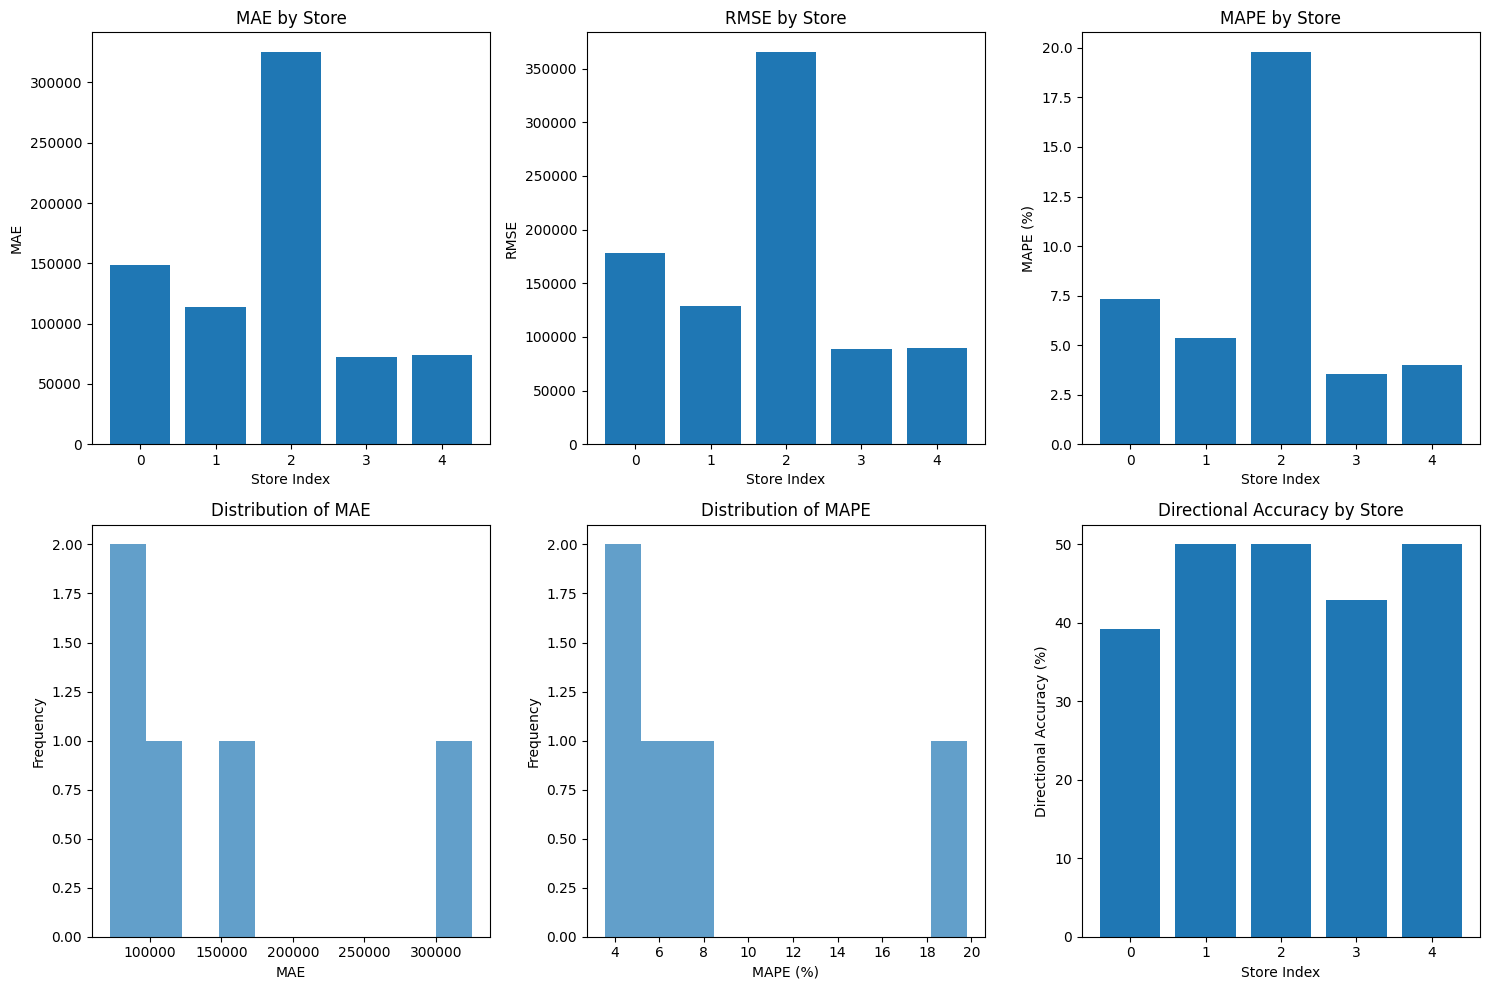

Model evaluation completed and results saved!


avg_directional_accuracy,▁
avg_mae,▁
avg_mape,▁
avg_rmse,▁
best_store_mae,▁
cv_store_13_folds,▁
cv_store_13_mae,▁
cv_store_13_mape,▁
cv_store_13_rmse,▁
cv_store_14_folds,▁
cv_store_14_mae,▁


In [120]:
# Block 5: Model Evaluation & Validation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import wandb

wandb.init(
    project="walmart-sales-forecasting",
    name="ARIMA_Model_Evaluation",
    tags=["ARIMA", "evaluation", "validation"]
)

print("=== BLOCK 5: MODEL EVALUATION & VALIDATION ===")

# Load trained models and data
try:
    trained_models = np.load('trained_arima_models.npy', allow_pickle=True).item()
    store_ts_data = pd.read_pickle('store_timeseries_data.pkl')
    print(f"Loaded {len(trained_models)} trained models")
except:
    print("Could not load trained models. Please run Block 4 first.")
    wandb.finish()
    exit()

def plot_forecast_comparison(store_id, actual_train, actual_test, forecast, title_suffix=""):
    """Plot actual vs predicted values"""

    plt.figure(figsize=(12, 6))

    # Plot training data
    plt.plot(actual_train.index, actual_train.values, label='Training Data', alpha=0.7, color='blue')

    # Plot actual test data
    plt.plot(actual_test.index, actual_test.values, label='Actual Test', alpha=0.8, color='green', linewidth=2)

    # Plot forecast
    plt.plot(actual_test.index, forecast, label='ARIMA Forecast', alpha=0.8, color='red', linestyle='--', linewidth=2)

    plt.axvline(x=actual_train.index[-1], color='black', linestyle=':', alpha=0.5, label='Train/Test Split')

    plt.title(f'Store {store_id} - ARIMA Forecast vs Actual {title_suffix}')
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    filename = f'forecast_comparison_store_{store_id}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

    return filename

def calculate_additional_metrics(actual, predicted):
    """Calculate additional evaluation metrics"""

    # Basic metrics
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    # Additional metrics
    smape = np.mean(2 * np.abs(actual - predicted) / (np.abs(actual) + np.abs(predicted))) * 100

    # Directional accuracy (how often forecast correctly predicts direction of change)
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    directional_accuracy = np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

    # Forecast bias
    bias = np.mean(predicted - actual)

    return {
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'smape': smape,
        'directional_accuracy': directional_accuracy,
        'bias': bias
    }

def perform_cross_validation(store_data, best_params, n_folds=3):
    """Perform time series cross-validation"""

    from statsmodels.tsa.arima.model import ARIMA

    ts = store_data.set_index('Date')['Weekly_Sales']
    n_obs = len(ts)

    # Calculate fold size
    fold_size = n_obs // (n_folds + 1)

    cv_results = []

    for fold in range(n_folds):
        # Define train/test for this fold
        train_end = fold_size * (fold + 2)
        test_start = train_end
        test_end = min(test_start + fold_size, n_obs)

        if test_end <= test_start:
            break

        train_data = ts.iloc[:train_end]
        test_data = ts.iloc[test_start:test_end]

        try:
            # Fit model
            model = ARIMA(train_data, order=best_params)
            fitted_model = model.fit()

            # Make forecast
            forecast = fitted_model.forecast(steps=len(test_data))

            # Calculate metrics
            metrics = calculate_additional_metrics(test_data.values, forecast)
            metrics['fold'] = fold
            metrics['train_size'] = len(train_data)
            metrics['test_size'] = len(test_data)

            cv_results.append(metrics)

        except Exception as e:
            print(f"Error in fold {fold}: {e}")
            continue

    return cv_results

# Comprehensive evaluation of all trained models
evaluation_results = {}

for store_id, model_info in trained_models.items():
    print(f"\n--- Evaluating Store {store_id} ---")

    # Get store data
    store_data = store_ts_data[store_ts_data['Store'] == store_id].copy()
    store_data = store_data.sort_values('Date')
    store_ts = store_data.set_index('Date')['Weekly_Sales']

    # Recreate train/test split used in training
    split_idx = int(len(store_ts) * 0.8)
    train_ts = store_ts.iloc[:split_idx]
    test_ts = store_ts.iloc[split_idx:]

    # Get forecast from trained model
    forecast = model_info['evaluation']['forecast']

    # Calculate comprehensive metrics
    detailed_metrics = calculate_additional_metrics(test_ts.values, forecast)

    # Create forecast comparison plot
    plot_filename = plot_forecast_comparison(store_id, train_ts, test_ts, forecast)

    # Perform cross-validation
    print(f"  Performing cross-validation for Store {store_id}...")
    cv_results = perform_cross_validation(store_data, model_info['best_params'])

    # Store comprehensive results
    evaluation_results[store_id] = {
        'basic_metrics': model_info['evaluation'],
        'detailed_metrics': detailed_metrics,
        'cv_results': cv_results,
        'plot_file': plot_filename,
        'best_params': model_info['best_params'],
        'model_aic': model_info['best_aic']
    }

    # Log individual store results
    log_data = {
        f'eval_store_{store_id}_mae': detailed_metrics['mae'],
        f'eval_store_{store_id}_rmse': detailed_metrics['rmse'],
        f'eval_store_{store_id}_mape': detailed_metrics['mape'],
        f'eval_store_{store_id}_smape': detailed_metrics['smape'],
        f'eval_store_{store_id}_directional_accuracy': detailed_metrics['directional_accuracy'],
        f'eval_store_{store_id}_bias': detailed_metrics['bias'],
        f'eval_store_{store_id}_forecast_plot': wandb.Image(plot_filename)
    }

    # Add CV results if available
    if cv_results:
        cv_mae = np.mean([result['mae'] for result in cv_results])
        cv_rmse = np.mean([result['rmse'] for result in cv_results])
        cv_mape = np.mean([result['mape'] for result in cv_results])

        log_data.update({
            f'cv_store_{store_id}_mae': cv_mae,
            f'cv_store_{store_id}_rmse': cv_rmse,
            f'cv_store_{store_id}_mape': cv_mape,
            f'cv_store_{store_id}_folds': len(cv_results)
        })

    wandb.log(log_data)

    print(f"  MAE: {detailed_metrics['mae']:.2f}")
    print(f"  RMSE: {detailed_metrics['rmse']:.2f}")
    print(f"  MAPE: {detailed_metrics['mape']:.2f}%")
    print(f"  Directional Accuracy: {detailed_metrics['directional_accuracy']:.1f}%")
    if cv_results:
        print(f"  CV MAE: {cv_mae:.2f} (±{np.std([r['mae'] for r in cv_results]):.2f})")

# Overall model performance analysis
print(f"\n=== OVERALL MODEL PERFORMANCE ===")

# Aggregate metrics across all stores
all_mae = [result['detailed_metrics']['mae'] for result in evaluation_results.values()]
all_rmse = [result['detailed_metrics']['rmse'] for result in evaluation_results.values()]
all_mape = [result['detailed_metrics']['mape'] for result in evaluation_results.values()]
all_directional = [result['detailed_metrics']['directional_accuracy'] for result in evaluation_results.values()]

overall_metrics = {
    'avg_mae': np.mean(all_mae),
    'std_mae': np.std(all_mae),
    'avg_rmse': np.mean(all_rmse),
    'std_rmse': np.std(all_rmse),
    'avg_mape': np.mean(all_mape),
    'std_mape': np.std(all_mape),
    'avg_directional_accuracy': np.mean(all_directional),
    'best_store_mae': min(all_mae),
    'worst_store_mae': max(all_mae),
    'models_evaluated': len(evaluation_results)
}

wandb.log(overall_metrics)

print(f"Models evaluated: {overall_metrics['models_evaluated']}")
print(f"Average MAE: {overall_metrics['avg_mae']:.2f} (±{overall_metrics['std_mae']:.2f})")
print(f"Average RMSE: {overall_metrics['avg_rmse']:.2f} (±{overall_metrics['std_rmse']:.2f})")
print(f"Average MAPE: {overall_metrics['avg_mape']:.2f}% (±{overall_metrics['std_mape']:.2f}%)")
print(f"Average Directional Accuracy: {overall_metrics['avg_directional_accuracy']:.1f}%")

# Create summary visualization
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.bar(range(len(all_mae)), all_mae)
plt.title('MAE by Store')
plt.xlabel('Store Index')
plt.ylabel('MAE')

plt.subplot(2, 3, 2)
plt.bar(range(len(all_rmse)), all_rmse)
plt.title('RMSE by Store')
plt.xlabel('Store Index')
plt.ylabel('RMSE')

plt.subplot(2, 3, 3)
plt.bar(range(len(all_mape)), all_mape)
plt.title('MAPE by Store')
plt.xlabel('Store Index')
plt.ylabel('MAPE (%)')

plt.subplot(2, 3, 4)
plt.hist(all_mae, bins=10, alpha=0.7)
plt.title('Distribution of MAE')
plt.xlabel('MAE')
plt.ylabel('Frequency')

plt.subplot(2, 3, 5)
plt.hist(all_mape, bins=10, alpha=0.7)
plt.title('Distribution of MAPE')
plt.xlabel('MAPE (%)')
plt.ylabel('Frequency')

plt.subplot(2, 3, 6)
plt.bar(range(len(all_directional)), all_directional)
plt.title('Directional Accuracy by Store')
plt.xlabel('Store Index')
plt.ylabel('Directional Accuracy (%)')

plt.tight_layout()
plt.savefig('model_evaluation_summary.png', dpi=300, bbox_inches='tight')
wandb.log({"evaluation_summary": wandb.Image('model_evaluation_summary.png')})
plt.show()

# Save evaluation results
np.save('evaluation_results.npy', evaluation_results)

# Log as artifact
eval_artifact = wandb.Artifact('evaluation_results', type='evaluation')
eval_artifact.add_file('evaluation_results.npy')
wandb.log_artifact(eval_artifact)

print("Model evaluation completed and results saved!")

wandb.finish()

In [121]:
# Block 6: Final Pipeline Creation
import pandas as pd
import numpy as np
import joblib
from datetime import datetime
import wandb

wandb.init(
    project="walmart-sales-forecasting",
    name="ARIMA_Final_Pipeline",
    tags=["ARIMA", "pipeline", "final-model"]
)

print("=== BLOCK 6: FINAL PIPELINE CREATION ===")

# Load all necessary data and results
try:
    trained_models = np.load('trained_arima_models.npy', allow_pickle=True).item()
    evaluation_results = np.load('evaluation_results.npy', allow_pickle=True).item()
    store_ts_data = pd.read_pickle('store_timeseries_data.pkl')
    print("All data loaded successfully")
except Exception as e:
    print(f"Error loading data: {e}")
    wandb.finish()
    exit()

class WalmartARIMAPipeline:
    """Complete ARIMA pipeline for Walmart sales forecasting"""

    def __init__(self):
        self.models = {}
        self.preprocessing_params = {}
        self.evaluation_metrics = {}
        self.is_fitted = False

    def add_store_model(self, store_id, arima_model, best_params, metrics):
        """Add a trained ARIMA model for a specific store"""
        self.models[store_id] = {
            'model': arima_model,
            'params': best_params,
            'metrics': metrics
        }

    def set_preprocessing_params(self, params):
        """Set preprocessing parameters"""
        self.preprocessing_params = params

    def predict_store(self, store_id, steps):
        """Make predictions for a specific store"""
        if store_id not in self.models:
            raise ValueError(f"No model available for store {store_id}")

        model_info = self.models[store_id]
        forecast = model_info['model'].forecast(steps=steps)
        return forecast

    def predict_multiple_stores(self, store_ids, steps):
        """Make predictions for multiple stores"""
        predictions = {}
        for store_id in store_ids:
            try:
                pred = self.predict_store(store_id, steps)
                predictions[store_id] = pred
            except Exception as e:
                print(f"Error predicting for store {store_id}: {e}")
                # Use fallback prediction
                predictions[store_id] = np.full(steps, 10000)  # Conservative fallback

        return predictions

    def get_model_info(self):
        """Get information about all models in the pipeline"""
        info = {}
        for store_id, model_data in self.models.items():
            info[store_id] = {
                'params': model_data['params'],
                'mae': model_data['metrics'].get('mae', 'N/A'),
                'rmse': model_data['metrics'].get('rmse', 'N/A'),
                'mape': model_data['metrics'].get('mape', 'N/A')
            }
        return info

    def get_best_performing_stores(self, metric='mae', top_n=5):
        """Get the best performing stores based on a metric"""
        store_metrics = []
        for store_id, model_data in self.models.items():
            if metric in model_data['metrics']:
                store_metrics.append((store_id, model_data['metrics'][metric]))

        # Sort by metric (lower is better for MAE, RMSE, MAPE)
        store_metrics.sort(key=lambda x: x[1])
        return [store_id for store_id, _ in store_metrics[:top_n]]

# Create the final pipeline
print("Creating final ARIMA pipeline...")

pipeline = WalmartARIMAPipeline()

# Add all trained models to the pipeline
for store_id, model_info in trained_models.items():

    # Get evaluation metrics
    eval_metrics = evaluation_results[store_id]['detailed_metrics']

    # Add model to pipeline
    pipeline.add_store_model(
        store_id=store_id,
        arima_model=model_info['model'],
        best_params=model_info['best_params'],
        metrics=eval_metrics
    )

    print(f"Added Store {store_id} model - ARIMA{model_info['best_params']} (MAE: {eval_metrics['mae']:.2f})")

# Set preprocessing parameters
preprocessing_info = {
    'aggregation_level': 'store',
    'train_test_split': 0.8,
    'min_observations': 40,
    'date_range': {
        'start': str(store_ts_data['Date'].min()),
        'end': str(store_ts_data['Date'].max())
    },
    'stores_modeled': list(trained_models.keys()),
    'total_stores_available': store_ts_data['Store'].nunique()
}

pipeline.set_preprocessing_params(preprocessing_info)

# Test the pipeline
print("\nTesting pipeline functionality...")

test_stores = list(trained_models.keys())[:3]  # Test with first 3 stores
test_predictions = pipeline.predict_multiple_stores(test_stores, steps=10)

print(f"Test predictions generated for {len(test_predictions)} stores")
for store_id, pred in test_predictions.items():
    print(f"  Store {store_id}: {len(pred)} predictions, mean={np.mean(pred):.2f}")

# Get pipeline performance summary
model_info = pipeline.get_model_info()
best_stores = pipeline.get_best_performing_stores(metric='mae', top_n=3)

print(f"\nPipeline Summary:")
print(f"  Total models: {len(pipeline.models)}")
print(f"  Best performing stores (by MAE): {best_stores}")

# Calculate overall pipeline metrics
all_mae = [info['mae'] for info in model_info.values() if info['mae'] != 'N/A']
all_rmse = [info['rmse'] for info in model_info.values() if info['rmse'] != 'N/A']
all_mape = [info['mape'] for info in model_info.values() if info['mape'] != 'N/A']

pipeline_metrics = {
    'total_models': len(pipeline.models),
    'avg_mae': np.mean(all_mae),
    'avg_rmse': np.mean(all_rmse),
    'avg_mape': np.mean(all_mape),
    'best_mae': min(all_mae),
    'worst_mae': max(all_mae),
    'best_performing_stores': best_stores,
    'stores_coverage': len(pipeline.models) / preprocessing_info['total_stores_available'] * 100
}

# Log pipeline metrics
wandb.log(pipeline_metrics)

print(f"  Average MAE: {pipeline_metrics['avg_mae']:.2f}")
print(f"  Average RMSE: {pipeline_metrics['avg_rmse']:.2f}")
print(f"  Average MAPE: {pipeline_metrics['avg_mape']:.2f}%")
print(f"  Store coverage: {pipeline_metrics['stores_coverage']:.1f}%")

# Save the final pipeline
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
pipeline_filename = f'walmart_arima_pipeline_{timestamp}.pkl'

joblib.dump(pipeline, pipeline_filename)
print(f"\nPipeline saved as: {pipeline_filename}")

# Create pipeline metadata
metadata = {
    'creation_date': timestamp,
    'model_type': 'ARIMA',
    'stores_modeled': list(trained_models.keys()),
    'preprocessing_params': preprocessing_info,
    'performance_metrics': pipeline_metrics,
    'model_details': model_info
}

metadata_filename = f'pipeline_metadata_{timestamp}.json'
import json
with open(metadata_filename, 'w') as f:
    json.dump(metadata, f, indent=2, default=str)

# Log as wandb artifacts
pipeline_artifact = wandb.Artifact(
    name="walmart_arima_pipeline",
    type="model",
    description="Complete ARIMA pipeline for Walmart sales forecasting",
    metadata=metadata
)
pipeline_artifact.add_file(pipeline_filename)
pipeline_artifact.add_file(metadata_filename)
wandb.log_artifact(pipeline_artifact)

# Log final summary
final_summary = {
    'pipeline_created': True,
    'pipeline_filename': pipeline_filename,
    'total_models_in_pipeline': len(pipeline.models),
    'pipeline_test_successful': len(test_predictions) > 0,
    'average_model_performance_mae': pipeline_metrics['avg_mae'],
    'ready_for_inference': True
}

wandb.log(final_summary)

print(f"\n{'='*60}")
print("ARIMA PIPELINE CREATION COMPLETED SUCCESSFULLY!")
print(f"{'='*60}")
print(f"Pipeline file: {pipeline_filename}")
print(f"Metadata file: {metadata_filename}")
print(f"Models included: {len(pipeline.models)}")
print(f"Ready for inference: Yes")
print(f"Uploaded to wandb: Yes")

wandb.finish()

=== BLOCK 6: FINAL PIPELINE CREATION ===
All data loaded successfully
Creating final ARIMA pipeline...
Added Store 20 model - ARIMA(2, 1, 2) (MAE: 148321.21)
Added Store 4 model - ARIMA(2, 1, 3) (MAE: 113804.24)
Added Store 14 model - ARIMA(2, 1, 1) (MAE: 325309.16)
Added Store 13 model - ARIMA(1, 1, 3) (MAE: 71957.05)
Added Store 2 model - ARIMA(1, 1, 3) (MAE: 74199.60)

Testing pipeline functionality...
Test predictions generated for 3 stores
  Store 20: 10 predictions, mean=2236583.90
  Store 4: 10 predictions, mean=2269319.58
  Store 14: 10 predictions, mean=2087659.92

Pipeline Summary:
  Total models: 5
  Best performing stores (by MAE): [13, 2, 4]
  Average MAE: 146718.25
  Average RMSE: 170083.38
  Average MAPE: 8.01%
  Store coverage: 11.1%

Pipeline saved as: walmart_arima_pipeline_20250705_1539.pkl

ARIMA PIPELINE CREATION COMPLETED SUCCESSFULLY!
Pipeline file: walmart_arima_pipeline_20250705_1539.pkl
Metadata file: pipeline_metadata_20250705_1539.json
Models included: 5
Rea

average_model_performance_mae,▁
avg_mae,▁
avg_mape,▁
avg_rmse,▁
best_mae,▁
stores_coverage,▁
total_models,▁
total_models_in_pipeline,▁
worst_mae,▁
average_model_performance_mae,146718.25258
avg_mae,146718.25258
